In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
from fnsa.classifier.data import load as load_data
from fnsa.classifier.util import cross_validate, evaluate, plot_confusion_matrix

from sklearn.externals import joblib

In [3]:
from fnsa.feature import FeatureExtractor, VERY_STRICT_F_TYPE, STRICT_F_TYPE, REGULAR_F_TYPE, FLUSH_F_TYPE
from fnsa.lexicon import Lexicon
from fnsa.scope import DRScopeDetector, IFScopeDetector
#from fnsa.graph import make_graph
from fnsa.util import *
from fnsa.classifier.util import evaluate, fit, split
import spacy

In [30]:
ftype = VERY_STRICT_F_TYPE
#ftype = STRICT_F_TYPE
#ftype = REGULAR_F_TYPE
#ftype = FLUSH_F_TYPE
nlp = spacy.load('en_core_web_sm')
lexicon = Lexicon(nlp)
dr_detector = DRScopeDetector()
if_detector = IFScopeDetector()
extractor = FeatureExtractor(lexicon, detectors=[dr_detector, if_detector], ftype=ftype)

Accuracy = 0.830.


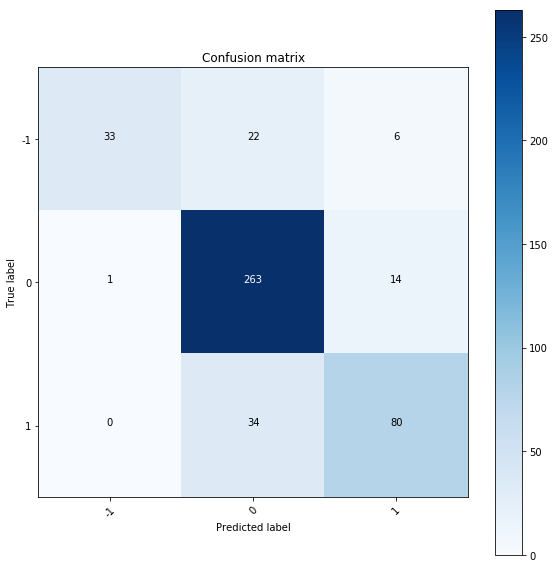

In [37]:
fname = 'all-agree-%d' % ftype
model = 'nbsvm'
codes = [-1, 0, 1]
code2sentiment = {-1:'-', 0:'=', 1:'+'}

sentences, X, y = load_data(fname + ".tsv")
sentences_train, X_train, y_train, sentences_test, X_test, y_test = split(sentences, X, y, test_size=0.2)
classifier = fit(X_train, y_train)
accuracy, cm = evaluate(classifier, X_test, y_test)
plot_confusion_matrix(cm, codes)
print("Accuracy = %0.3f." % (accuracy,))

In [38]:
def important_features(classifier, n=20):
    vectorizer = classifier.named_steps['vectorizer']
    transformer = classifier.named_steps['transformer'] 
    estimator = classifier.named_steps['estimator'] 
    class_labels = estimator.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class_negative = sorted(zip(estimator.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class_neutral = sorted(zip(estimator.feature_count_[1], feature_names),reverse=True)[:n]
    topn_class_positive = sorted(zip(estimator.feature_count_[2], feature_names),reverse=True)[:n]
    print("%64s" % ("Most Important Features for Classification"))
    print("%64s" % ("=" * len("Most Important Features for Classification")))
    print("%16s\t%22s\t%30s\n" % ("Negative", "Neutral", "Positive"))
    for i in range(n):
        coef_negative, feat_negative = topn_class_negative[i]
        coef_neutral, feat_neutral = topn_class_neutral[i]
        coef_positive, feat_positive = topn_class_positive[i]
        print("[-] %6.2f: %-16s\t[=] %6.2f: %-16s\t[+] %6.2f: %-16s\t" % (coef_negative, feat_negative, coef_neutral, feat_neutral, coef_positive, feat_positive)) 
    return
important_features(classifier, n=25)

                      Most Important Features for Classification
        Negative	               Neutral	                      Positive

[-] 128.06: fe_+_-_=        	[=] 659.00: fi_=_=          	[+] 247.32: fe_+_+_=        	
[-]  40.00: fi_=_=          	[=] 227.35: lm_+_=          	[+]  61.21: lm_+_=          	
[-]  22.74: lm_-_=          	[=] 112.17: lm_-_=          	[+]  50.00: fi_=_=          	
[-]   6.86: fe_+_-_= lm_-_= 	[=]  39.65: lm_+_= lm_+_=   	[+]  20.23: lm_+_= lm_+_=   	
[-]   6.61: fe_-_-_=        	[=]  24.12: lm_-_rev        	[+]  17.14: fe_+_+_= fe_+_+_=	
[-]   6.34: fe_-_+_=        	[=]  23.38: fe_+_+_=        	[+]  14.36: fe_-_-_=        	
[-]   5.61: fe_+_-_rev      	[=]  10.61: lm_+_= lm_-_=   	[+]  13.39: lm_-_=          	
[-]   5.59: lm_+_=          	[=]   9.68: lm_+_mod        	[+]   8.79: lm_+_= fe_+_+_= 	
[-]   5.19: fe_+_-_= fe_+_-_=	[=]   8.53: lm_-_= lm_-_=   	[+]   8.26: fe_+_+_= lm_+_= 	
[-]   5.00: fe_+_-_lit      	[=]   5.63: lm_-_= lm_+_=   	[+]   8.14:

In [29]:
def show_examples(sentiment='-', feature='fe_+_-_rev'):
    examples = [i for i, x in enumerate(X) if x == feature and CODE_TO_SENTIMENT[y[i]] == sentiment]
    for i in examples: 
        doc, features, prediction = predict(classifier, extractor, sentences[i])
        prediction = CODE_TO_SENTIMENT[prediction]
        print("[%s||%s] %d. %s" % (prediction, CODE_TO_SENTIMENT[y[i]], i, sentences[i]))
        show(doc, include_text=False, include_tree=False)
        print(features)
        print('-----')

show_examples(sentiment='-', feature='fe_+_+_=')

[+||-] 1910. TietoEnator was down 1.13 pct to 18.38 , extending recent lows after last week 's second-quarter report , dealers said .
 [TietoEnator/xe:org] was [down/dr:-] [1.13/xe:car] pct to [18.38/xe:car] , [extending/dr:+] recent [lows/dr:-] after [last week 's/xe:dat] [second-quarter/xe:dat] report , [dealers/fe:+] said .
fe_+_+_=
-----


In [ ]:
vectorizer = classifier.named_steps['vectorizer']
vectorizer.get_feature_names()

In [ ]:
analyzer = vectorizer.build_analyzer()
analyzer('fe_-_+_=')

In [39]:
for sentence in [
    'Profit dropped by 33% from the third quarter.',
    'Earnings per share ( EPS ) amounted to $0.98 , up from the loss of €0.02 .',
    "TietoEnator was down 1.13 pct to 18.38 , extending recent lows after last week 's second-quarter report , dealers said ."
]:
    doc, features, prediction = predict(classifier, extractor, sentence)
    prediction = CODE_TO_SENTIMENT[prediction]
    show(doc, include_text=True, include_tree=True)
    print("%s -->> %s" % (features, prediction))
    print('-----')

Profit dropped by 33% from the third quarter.
 [Profit/fe:+] [dropped/dr:-] by [33%/xe:per] from [the third quarter/xe:dat] .
       dropped                 
   _______|___________          
  |       by         from      
  |       |           |         
Profit   33%   the third quarte
                      r        

fe_+_-_= -->> -
-----
Earnings per share ( EPS ) amounted to $0.98 , up from the loss of €0.02 .
 [Earnings per share/fe:+] ( [EPS/fe:+] ) amounted to $ [0.98/xe:mon] , [up/dr:+] from the [loss/fe:-] of € [0.02/xe:mon] .
              amounted              
       __________|__________         
      |          |          up      
      |          |          |        
      |          |         from     
      |          |          |        
      |          |         loss     
      |          |       ___|____    
Earnings per     to     |        of 
    share        |      |        |  
      |          |      |        |   
     EPS        0.98    |       0.02
      |  

In [ ]:
y_pred_train = classifier.predict(X_train)
cnt = 0
for i in range(len(y_pred_train)):
    #print(sentences_train[i], X_train[i], y_pred_train[i], y_train[i])
    predicted = CODE_TO_SENTIMENT[y_pred_train[i]]
    actual = CODE_TO_SENTIMENT[y_train[i]]
    print("[%s||%s] %s\n\t%s" % (predicted, actual, X_train[i], sentences_train[i]))
    cnt += 1
    if cnt == 10: break

In [ ]:
for sentence in [
    'Construction is scheduled to start in April-June 2007 and to be completed in early 2008 .',
    'At this growth rate , paying off the national debt will be extremely painful .',
    'Major Order in India: Comptel Corporation has received a significant long-term order for mediation and provisioning solutions being used by a leading operator in India .',
    'Production levels have been agreed with producers a long time ago , so a fall in consumption will lead to losses .',
    'Operating profit decreased to nearly EUR 1.7 mn , however .',
    'The move was triggered by weak demand for forestry equipment and the uncertain market situation .',
    'Finnish KCI Konecranes has been awarded an order for four hot metal ladle cranes by Indian steel producer Bhushan Steel & Strips to be delivered in 2007 .',
    """28 October 2010 - Finnish wood products technology supplier Raute Oyj HEL : RUTAV said today it swung to a net profit of EUR3m for the first nine months of 2010 versus a net loss of EUR5 .2 m for the same period a year earlier .""",
    """` The stable outlook reflects Nokia 's strong market position in the global mobile handset market , strong cash flow generation , and very conservative balance sheet , ' said Raab .""",
]:
    doc, features = extractor(sentence)
    show(doc, include_text=True)
    features_as_text = " ".join(features)
    print(features, '-->>', code2sentiment[classifier.predict([features_as_text])[0]])
    print('-----')

In [ ]:
code2position = {-1:0, 0:1, 1:2}

def correct_confidence(classifier, X, y, index):
    x = X[index]
    probs = classifier.predict_proba([x])[0]
    position = code2position[y[index]]
    return probs[position]    

def show_classification_result(classifier, sentences, X, y, y_predicted, index):
    sentence = sentences[index]
    actual = code2sentiment[y[index]]
    predicted = code2sentiment[y_predicted[index]]
    print("%d [%s||%s] %s" % (index, predicted, actual, sentence))
    doc, features = extractor(sentence)
    show(doc, index=None, include_text=False, include_tree=False)
    print("<<%s>>" % X[index])
    show_tree(doc)


In [ ]:
%%time
indices = range(len(y_test))
indices = sorted(indices, key=lambda index: correct_confidence(classifier, X_test, y_test, index))
y_predicted = classifier.predict(X_test)

In [ ]:
import random
n = len(y_test)
start = 0
stop = 10
candidate_indices = indices[:48]

index = random.choice(candidate_indices)
#index = 233
show_classification_result(classifier, sentences_test, X_test, y_test, y_predicted, index)

In [ ]:
pattern = 'fe_+_-_='
value = 1
train_instances = [i for i in range(len(y_train)) if X_train[i] == pattern and y_train[i] == value]
n_train = len(train_instances)
test_instances = [i for i in range(len(y_test)) if X_test[i] == pattern and y_test[i] == value]
n_test = len(test_instances)
pred_instances = [i for i in range(len(y_test)) if X_test[i] == pattern and y_predicted[i] == value]
n_pred = len(pred_instances)
print("pattern = %s, value = %d, n-train = %d, n-test = %d, n-pred = %d" % (pattern, value, n_train, n_test, n_pred))

In [ ]:
from collections import Counter

bags = set([])
for xx in X_test:
    items = xx.split()
    items.sort()
    bag = ", ".join(items)
    bags.add(bag)
print(len(bags))
for bag in bags: print(bag)

In [ ]:
for i in train_instances:
    print(y_train[i], sentences_train[i], X_train[i])

In [ ]:
%%time 
sentences, X, y = load_data(fname + ".tsv")
indices = range(len(y))
indices = sorted(indices, key=lambda index: correct_confidence(classifier, X, y, index))
y_predicted = classifier.predict(X)

accuracy, cm = evaluate(classifier, X, y)
plot_confusion_matrix(cm, codes)
print("Accuracy = %0.3f." % (accuracy,))

In [ ]:
def predict(classifier, sentence):
    doc, features = extractor(sentence)
    features = [token.lower() for token in features]
    print(" ".join(features))
    return classifier.predict(features)[0]
    
sentence = "The Group's operative EBIT will probably be negative."
predict(classifier, sentence)

## Sentence-Level Sentiment Analysis of Financial News Test Dataset

In [ ]:
fname = 'ad-hoc'
if include_words: fname = '%s-with-words' % fname
sl_sentences, sl_X, sl_y = load_data(fname + ".tsv")
#sl_y = [-1 if code == 0 else 1 for code in sl_y]
accuracy, cm = evaluate(classifier, sl_X, sl_y)
plot_confusion_matrix(cm, codes)
print("Accuracy = %0.3f." % (accuracy,))

In [ ]:
indices = range(len(sl_y))
indices = sorted(indices, key=lambda index: correct_confidence(classifier, sl_X, sl_y, index))

sl_y_predicted = classifier.predict(sl_X)

In [ ]:
start = 100
stop = 110
for index in indices[start:stop]:
    show_classification_result(classifier, sl_sentences, sl_X, sl_y, sl_y_predicted, index)
    print('-----')

In [ ]:
path = './model/nbsvm-%s.pkl' % fname
joblib.dump(classifier, path)
classifier_loaded = joblib.load(path)